# Cyclic Prefix in OFDM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from pathlib import Path
from ipywidgets import interact
import inspect
from OFDM.channel import addCP, removeCP

In [2]:
# Define Figsize
matplotlib.rcParams['figure.figsize'] = (10,4)
matplotlib.rcParams['animation.writer'] = 'avconv'

# Defind arrow style
doubleArrow = {'arrowprops':dict(arrowstyle="<->")}
arcArrow = {'arrowprops':dict(arrowstyle='->',connectionstyle='arc3,rad=-0.2')}
arcArrowUp = {'arrowprops':dict(arrowstyle='->',connectionstyle='arc3,rad=0.3')}

# workaround function for strange interact implementation
def showInInteract():
    if 'interaction.py' in inspect.stack()[2][1]:
        plt.show()
        
save_fig = True # To save plot during simulation
save_folder = Path("results") # Where to save the figures
save_format = "pdf" # Save as what type
def Save_fig(save_name : str):
    plt.savefig(save_folder/(save_name+"."+save_format), bbox_inches='tight')        

## Parameters setup

In [3]:
T_S = 128     # OFDM block length (i.e. subcarrier count)
T_G = 32      # Length of OFDM CP

ofdm1 = np.arange(T_S)          # Generate some arbitrary signal for one OFDM block
ofdm2 = 2*T_S + np.arange(T_S)  # Generate some arbitrary signal for another OFDM block
symb1 = addCP(ofdm1, T_G)
symb2 = addCP(ofdm2, T_G)

# concatenate both blocks into a single signal
signal = np.hstack([symb1, symb2])
t = np.arange(len(signal)) - T_S - T_G - T_G

As we see, the CP of an OFDM symbol is obtained by prepending a copy of the last $N_{CP}$ samples from the end of the OFDM signal to its beginning. This way we obtain a circular signal structure, i.e. the first $N_{CP}$ and last $N_{CP}$ samples are equal in each OFDM symbol.

Let us have a more detailed look at the OFDM signal structure:

In [4]:
def showOFDMStructure(t, sig, withTicks=True):
    H = 20
    I = np.tile(sig.reshape(1,-1), (H, 1))
    y = np.arange(H)
    plt.pcolormesh(t, y, I)
    plt.axis('equal')
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().patch.set_visible(False)
    if withTicks:
        plt.xticks([-T_S-2*T_G, -T_S-T_G, -T_G, 0, T_S])
        # plt.gca().set_xticklabels([-T_S-2*T_G, -T_S-T_G, -T_G, 0, T_S])
        plt.gca().set_xticklabels(['$-T_S-2T_G$', '$-T_S-T_G$', '$-T_G$', '$0$', '$T_S$'])
    else:
        plt.gca().get_xaxis().set_visible(False)

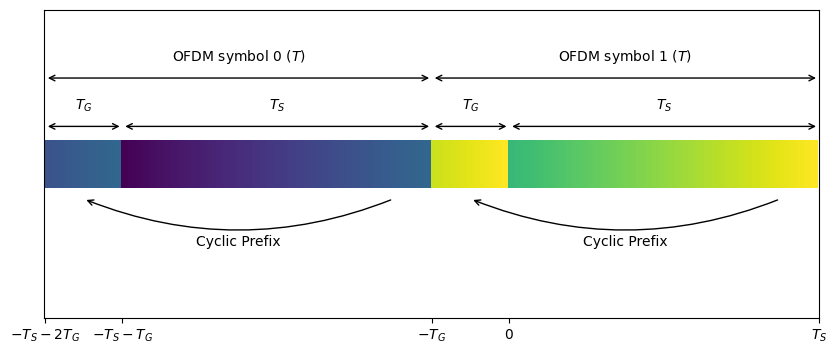

In [5]:
showOFDMStructure(t, signal)
plt.annotate(text="",xytext=(-T_G,25),          xy=(0,25), **doubleArrow);              plt.text(-T_G/2, 30, '$T_G$', va='bottom', ha='center')
plt.annotate(text="",xytext=(-T_S-2*T_G,25),    xy=(-T_S-T_G,25), **doubleArrow);       plt.text(-T_S-T_G-T_G/2, 30, '$T_G$', va='bottom', ha='center')
plt.annotate(text="",xytext=(-T_S-T_G,25),      xy=(-T_G,25), **doubleArrow);           plt.text(-T_G-T_S/2, 30, '$T_S$', va='bottom', ha='center')
plt.annotate(text="",xytext=(-0,25),            xy=(T_S,25), **doubleArrow);            plt.text(T_S/2, 30, '$T_S$', va='bottom', ha='center')
plt.annotate(text="",xytext=(-T_G,45),          xy=(T_S,45), **doubleArrow);            plt.text((T_S-T_G)/2, 50, 'OFDM symbol 1 ($T$)', ha='center', va='bottom')
plt.annotate(text="",xytext=(-T_S-2*T_G,45),    xy=(-T_G,45), **doubleArrow);           plt.text(-T_S-T_G+(T_S-T_G)/2, 50, 'OFDM symbol 0 ($T$)', ha='center', va='bottom')
plt.annotate(text="",xytext=(T_S-T_G/2, -5),    xy=(-T_G/2,-5), **arcArrow);            plt.text((T_S-T_G)/2, -20, 'Cyclic Prefix', va='top', ha='center')
plt.annotate(text="",xytext=(-T_G-T_G/2, -5),   xy=(-T_S-T_G-T_G/2,-5), **arcArrow);    plt.text((T_S-T_G)/2-T_S-T_G, -20, 'Cyclic Prefix', va='top', ha='center')
Save_fig("CP")
plt.show()

In the above figure, we see two subsequent OFDM symbols, each having a dedicated CP. The colors encode the signal value. The cyclic prefix at the beginning of each OFDM symbol shows a copy of the color of end of the OFDM symbol. When the signal is demodulated, the N-point FFT is taken at the position after the CP, which is indicated with *FFT window*. 

Now, let us consider, what happens when this signal $x[n]$ is sent over a linear time-invariant (LTI) multipath channel. We know, in the discrete domain, we can model this channel with its impulse response $h[n]$. Let us choose an exponentially decaying impulse response and truncate it after $L=20$ samples.

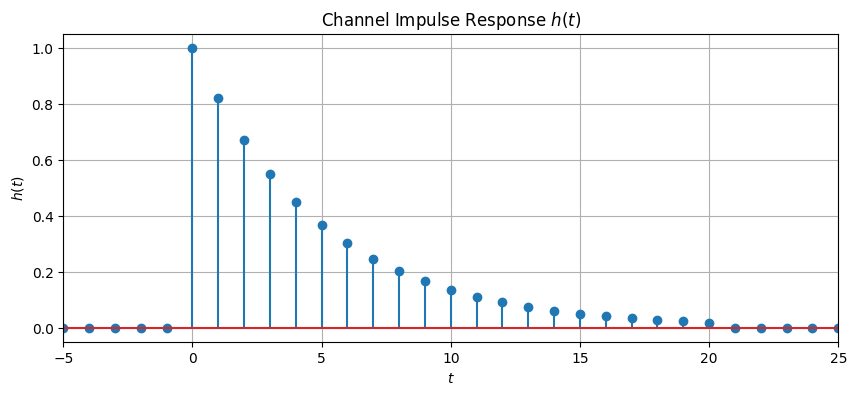

In [6]:
L = 20
h = lambda t: (t >= 0) * (t <= L) * np.exp(-0.2*t)
plt.stem(t, h(t))
plt.xlim((-5, L+5))
plt.grid(True)
plt.xlabel('$t$'); plt.ylabel('$h(t)$')
plt.title('Channel Impulse Response $h(t)$')
plt.show()

## 1) The Cyclic Prefix inhibits inter-symbol interference (ISI) between adjacent OFDM symbols
Then, the signal at the receiver $y[n]$ (ignoring the noise) is given by the (linear) convolution of the transmitted signal with the channel impulse response, i.e.

$$y[n] = h[n]*x[n].$$

More explicitely we can write the convolution as a sum

$$y[n] = \sum_{n'=-\infty}^{\infty} h[n']\cdot x[n-n'].$$

Now, since we know that $h[n]\neq0$ only for $n=0,\dots,L-1$, we can also write this a
$$y[n] = \sum_{n'=0}^{L-1}h[n']\cdot x[n-n'].$$
This means, the output signal $y[n]$ at time $n$ depends only on the previous $L$ samples of the transmit signal. Let us illustrate this with the following figure. We see how the channel impulse response is sliding over the transmit signal and we also see that the output of the convolution at time $n_0$ only depends on the last $L$ samples. 

In [7]:
def showNoISIBetweenBlocks(n0):
    plt.gcf().clear()
    showOFDMStructure(t, signal)
    plt.plot(t, 20*h(n0-t), 'k', lw=2)
    plt.annotate(xytext=(n0,25), xy=(n0-L,25), text="", **doubleArrow)
    plt.axvline(n0)
    plt.text(n0+2,50,'$n_0$', ha='left', fontsize=14)
    plt.text(n0-L+L/2, 30, 'Convolution window', ha='center', va='bottom')
    plt.text(-T_S-T_G, 40, '$n_0=$%d' % n0, bbox=dict(facecolor='white'))
    plt.annotate(xytext=(0,-5), xy=(T_S-1,-5), text="", **doubleArrow)
    plt.text(T_S/2, -10, '$T_S$ (FFT window)', va='top', ha='center')
    plt.show()

We can see the following: As soon as the convolution output at $n_0$ enters the FFT window, the convolution window is entirely located on the cyclic prefix. This means, that no interference from the previous OFDM symbol is smeared into the currently received OFDM symbol. Hence, there is no inter-symbol interference between adjacent OFDM symbols. Instead, the convolution output within the FFT window only depends on the signal of the current OFDM symbol, because the CP contains an exact copy of the end of the OFDM symbol. 

Naturally, this technique only works, if the channel impulse response is shorter than the cyclic prefix. If the CP is not long enough, it cannot completely mitigate ISI and the detection performance will become worse. 

In [8]:
interact(showNoISIBetweenBlocks, n0=(-50, 50));

interactive(children=(IntSlider(value=0, description='n0', max=50, min=-50), Output()), _dom_classes=('widget-…

## 2) The Cyclic Prefix converts the linear convolution into a circular convolution

To understand this fact, let us create two adjacent, a little bit more elaborate, OFDM symbols.

In [9]:
# Generate some random OFDM signals
np.random.seed(3)
td1 = abs(T_S*np.fft.ifft(np.random.randn(5)+1j*np.random.randn(5), T_S))
td2 = abs(T_S*np.fft.ifft(np.random.randn(5)+1j*np.random.randn(5), T_S))
f = max(td1.max(), td2.max())
td1 *= 5/f; td2 *= 5/f
# Add CP and join two blocks together
td1_withCP = addCP(td1, T_G)
td2_withCP = addCP(td2, T_G)
td_full = np.hstack([td1_withCP, td2_withCP])

Let's have a look at the resulting signal. As we see, two adjacent symbols, separated by a cyclic prefix, and the cyclic prefix contains a copy of the end of each symbol.

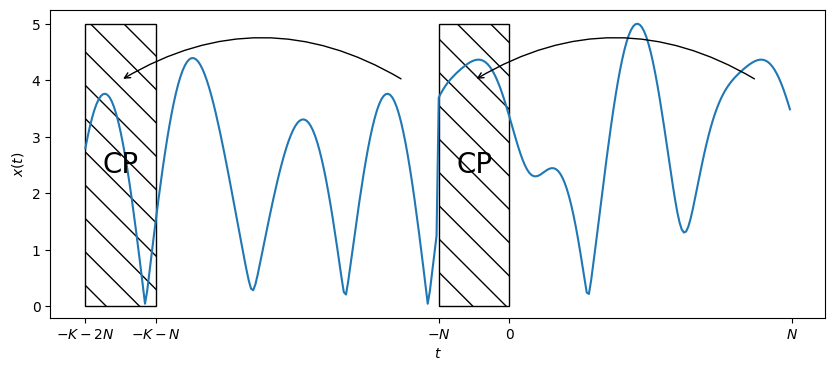

In [10]:
plt.plot(t, td_full)
plt.xticks([-T_S-2*T_G, -T_S-T_G, -T_G, 0, T_S])
plt.gca().set_xticklabels(['$-K-2N$', '$-K-N$', '$-N$', '$0$', '$N$'])
plt.gca().add_patch(patches.Rectangle((-T_G,0), T_G, 5, fill=None, hatch='\\'))
plt.text(-T_G/2, 2.5, 'CP', ha='center', va='center', fontsize=20)
plt.gca().add_patch(patches.Rectangle((-T_S-2*T_G,0), T_G, 5, fill=None, hatch='\\'))
plt.text(-T_S-T_G-T_G/2, 2.5, 'CP', ha='center', va='center', fontsize=20)
plt.annotate(xy=(-T_G/2, 4), xytext=(T_S-T_G/2, 4), text="", **arcArrowUp)
plt.annotate(xy=(-T_S-T_G-T_G/2, 4), xytext=(-T_G-T_G/2, 4), text="", **arcArrowUp)
plt.xlabel('$t$'); plt.ylabel('$x(t)$')
plt.show()

Now, lets see again what happens, if this signal is linearly convolved with the channel impulse response.

In [11]:
def showOFDMConvolution(shift):
    plt.gcf().clear()
    ax1 = plt.subplot(211)
    t_cyc = np.arange(T_S+T_G)-T_G
    h_cyc = h(shift-t_cyc)
    plt.plot(t_cyc, h_cyc)
    plt.plot(t_cyc, td2_withCP)
    plt.plot(t_cyc, h_cyc * td2_withCP)
    plt.fill_between(t_cyc, 0, h_cyc * td2_withCP, color='r', alpha=0.5, hatch='//')
    plt.xlim((-T_G, T_S-1)); plt.ylim((0,6))
    plt.xticks([-T_G, 0, T_S-1]); plt.gca().set_xticklabels(['$-N_{CP}$', '$0$', '$N$'])
    plt.axvline(0, color='k')
    plt.gca().add_patch(patches.Rectangle((-T_G,0), T_G, 6, fill=None, lw=0, hatch="\\"))
    plt.text(-T_G/2, 2.5, "CP", ha='center', va='center', fontsize=20)
    
    ax2 = plt.subplot(212)
    t_part = np.arange(T_S)
    h_part = h((shift-t_part)%T_S)
    plt.plot(t_part, h_part)
    plt.plot(t_part, td2)
    plt.plot(t_part, h_part * td2)
    plt.fill_between(t_part, 0, h_part * td2, color='r', alpha=0.5, hatch='//')
    plt.xlim((-T_G, T_S-1)); plt.ylim((0,6))
    plt.xticks([-T_G, 0, T_S-1]); plt.gca().set_xticklabels(['$-N_{CP}$', '$0$', '$N$'])
    plt.axvline(0, color='k')
    plt.gca().add_patch(patches.Rectangle((-T_G,0), T_G, 6, fill=None, lw=0, hatch="\\"))
    plt.text(-T_G/2, 2.5, "CP", ha='center', va='center', fontsize=20)

    if shift < L:
        con = patches.ConnectionPatch(xyA=(T_S-L/4, 0.5), xyB=(-L/4, -0.5),
                                      coordsA='data', coordsB='data',
                                      axesB=ax1, axesA=ax2, clip_on=False,
                                      connectionstyle="bar,angle=-0,fraction=0.18",
                                      arrowstyle="<->", lw=2)
        con.set_annotation_clip(False)
        plt.gca().add_artist(con)
    plt.tight_layout()
    plt.show()

In [12]:
interact(showOFDMConvolution, shift=(0, T_S-1));

interactive(children=(IntSlider(value=63, description='shift', max=127), Output()), _dom_classes=('widget-inte…

In the top figure we show the linear convolution of the channel with the signal, over the duration of the FFT window which will be used for demodulating the signal. We see, how the channel, when it enters the FFT window, convolves values from the CP region into the FFT window. This operation is still a linear convolution. However, we know that the CP is just a copy of the end of the OFDM symbol. Hence, we can understand the linear convolution over the CP also as a [circular convolution](http://dspillustrations.com/pages/posts/misc/circular-convolution-example.html) within the OFDM FFT window: When the channel impulse response is above the CP area, this is equivalent to the channel impulse response being wrapped around on the FFT window, and smearing the end of the block into the beginning of the block.

Again, this naturally only works exactly, if the channel impulse response is shorter than the cyclic prefix. Otherwise, we suffer from inter-symbol interference, which cannot be represented by the circular convolution on the FFT window.

Hence, we can write the expression for the received signal within the FFT window also with a circular convolution:

$$\begin{align}y[n] &= \sum_{n'=0}^{L-1}h[n']\cdot x[n-n']&&\text{Linear convolution}\\
y[n]&=\sum_{n'=0}^{L-1}h[n']\cdot x[(n-n')_N]&&\text{Circular convolution}\end{align},$$

where $(n'-n)_N$ denotes the remainder of dividing $n'-n$ by $N$. It's only this property of OFDM which allows to perform the one-tap equalization with the channel impulse response. The [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem "Wikipedia Link") in discrete domain states

$$\text{DFT}_N\{h[n]\otimes x[n]\}=H[k]X[k],$$

i.e. after performing the DFT over the FFT window we have

$$Y[k]=H[k]X[k],$$

and we know that $H[k]$ contains the QAM symbols that were sent from the transmitter. Then, we can perform the simple equalization 

$$\hat{X}[k]=\frac{Y[k]}{H[k]}$$

to get back to the transmitted data symbols. It's exactly this propertly of OFDM which made it so popular for being used in multipath fading channels.

## Summary
The cyclic prefix (CP) of OFDM provides two benefits:
   - It inhibits ISI between subsequent OFDM symbols.
   - It turns linear convolution into circular convolution with the FFT window.

Only circular convolution allows to apply the convolution theorem and use the single-tap equalizer.

The CP only works correctly, if it is longer than the channel impulse response.